### Preprocessing K2 few-tilt precession data, example with manual alignment for thick sample


---

''Multi-angle precession electron diffraction (MAPED): a versatile approach to 4D-STEM precession''

Stephanie M. Ribet [1], Rohan Dhall [1], Colin Ophus [2], Karen C. Bustillo [1]

[1] National Center for Electron Microscopy, Molecular Foundry, Lawrence Berkeley National Laboratory

[2] Department of Materials Science and Engineering, Stanford University


In [1]:
import numpy as np
import py4DSTEM
from emdfile import tqdmnd
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation

### define file paths

In [2]:
data_path = ''
file_path_0 = data_path + 'KB_0519_01.dm4' # tilt 0
file_path_1 = data_path + 'KB_0519_03.dm4' # tilt 1
file_path_2 = data_path + 'KB_0519_04.dm4' # tilt 2
file_path_3 = data_path + 'KB_0519_05.dm4' # tilt 3
file_path_4 = data_path + 'KB_0519_06.dm4' # tilt 4

### dc0

In [3]:
dc0 = py4DSTEM.import_file(file_path_0).bin_Q(2)

In [4]:
dc0.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (240, 224) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

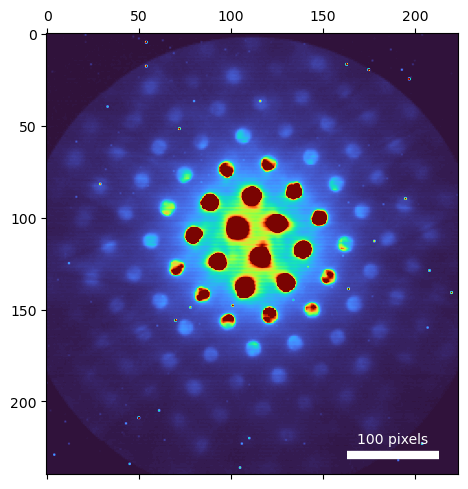

In [5]:
py4DSTEM.show(
    dc0.tree('dp_mean'),
    cmap = "turbo"
    # vmax = 1
    
)

105.92993755318625 104.5345940381521


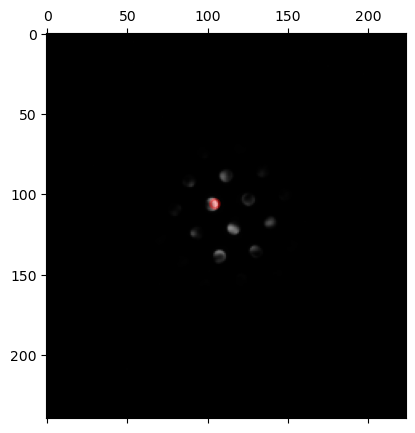

In [6]:
probe_semiangle, probe_qx0, probe_qy0 = dc0.get_probe_size(
    plot = True,
    # thresh_upper = 0.1
)

print(probe_qx0, probe_qy0)

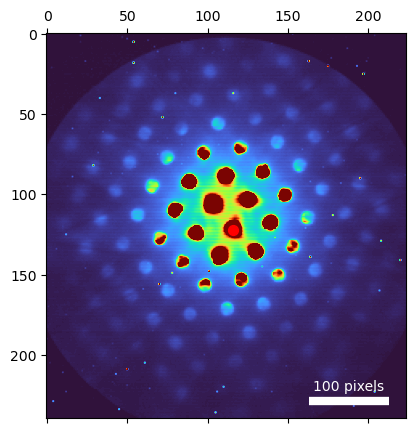

In [7]:
center_guess = (122, 116)

py4DSTEM.visualize.show_points(
    dc0.tree('dp_mean'),
    x = center_guess[0], 
    y = center_guess[1],
    cmap = "turbo"
    
)

In [8]:
dc0.calibration.qx0_mean = center_guess[0]
dc0.calibration.qxy_mean = center_guess[1]

In [9]:
dc0.get_virtual_image(
    geometry = ((0,0), (probe_semiangle + 5,50)),
    mode = "annular",
    name = "DF",
    centered = True
    
)

100%|████████████████████████████████| 12000/12000 [00:00<00:00, 36183.50it/s]


VirtualImage( A 2-dimensional array of shape (100, 120) called 'DF',
              with dimensions:

                  dim0 = [0,1,2,...] pixels
                  dim1 = [0,1,2,...] pixels
)

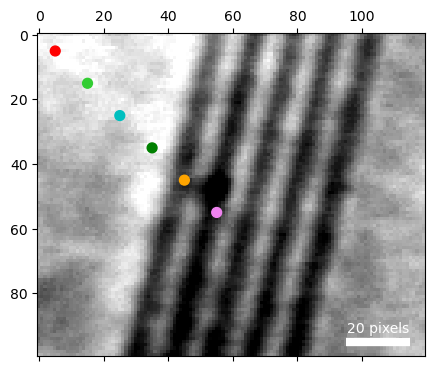

In [10]:
rxs = np.arange(6) * 10 + 5 
rys = np.arange(6) * 10  + 5

colors=['r','limegreen','c','g','orange', 'violet']

py4DSTEM.visualize.show_points(
    dc0.tree('DF'),
    x=rxs,
    y=rys,
    pointcolor=colors,
)


overflow encountered in exp


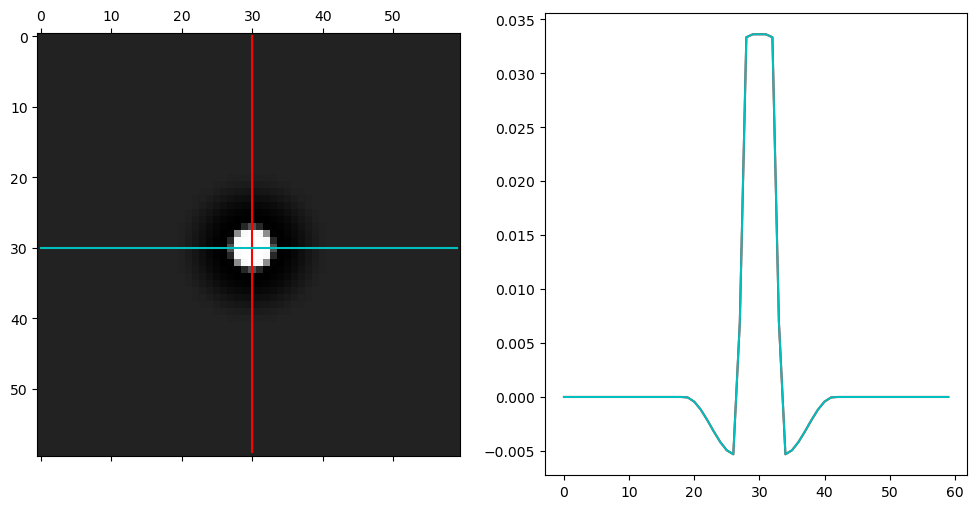

In [11]:
#make synthetic probe

probe = py4DSTEM.Probe.generate_synthetic_probe(
    radius = probe_semiangle,
    width = 0.7,
    Qshape = dc0.Qshape
)

probe.get_kernel(
    mode = 'sigmoid',
    origin = (dc0.Qshape[0]/2,dc0.Qshape[1]/2),
    radii = (probe_semiangle * 1.2,
             probe_semiangle * 4
    )
)

py4DSTEM.visualize.show_kernel(
    probe.kernel,
    R = 30,
    L = 30,
    W = 1
)


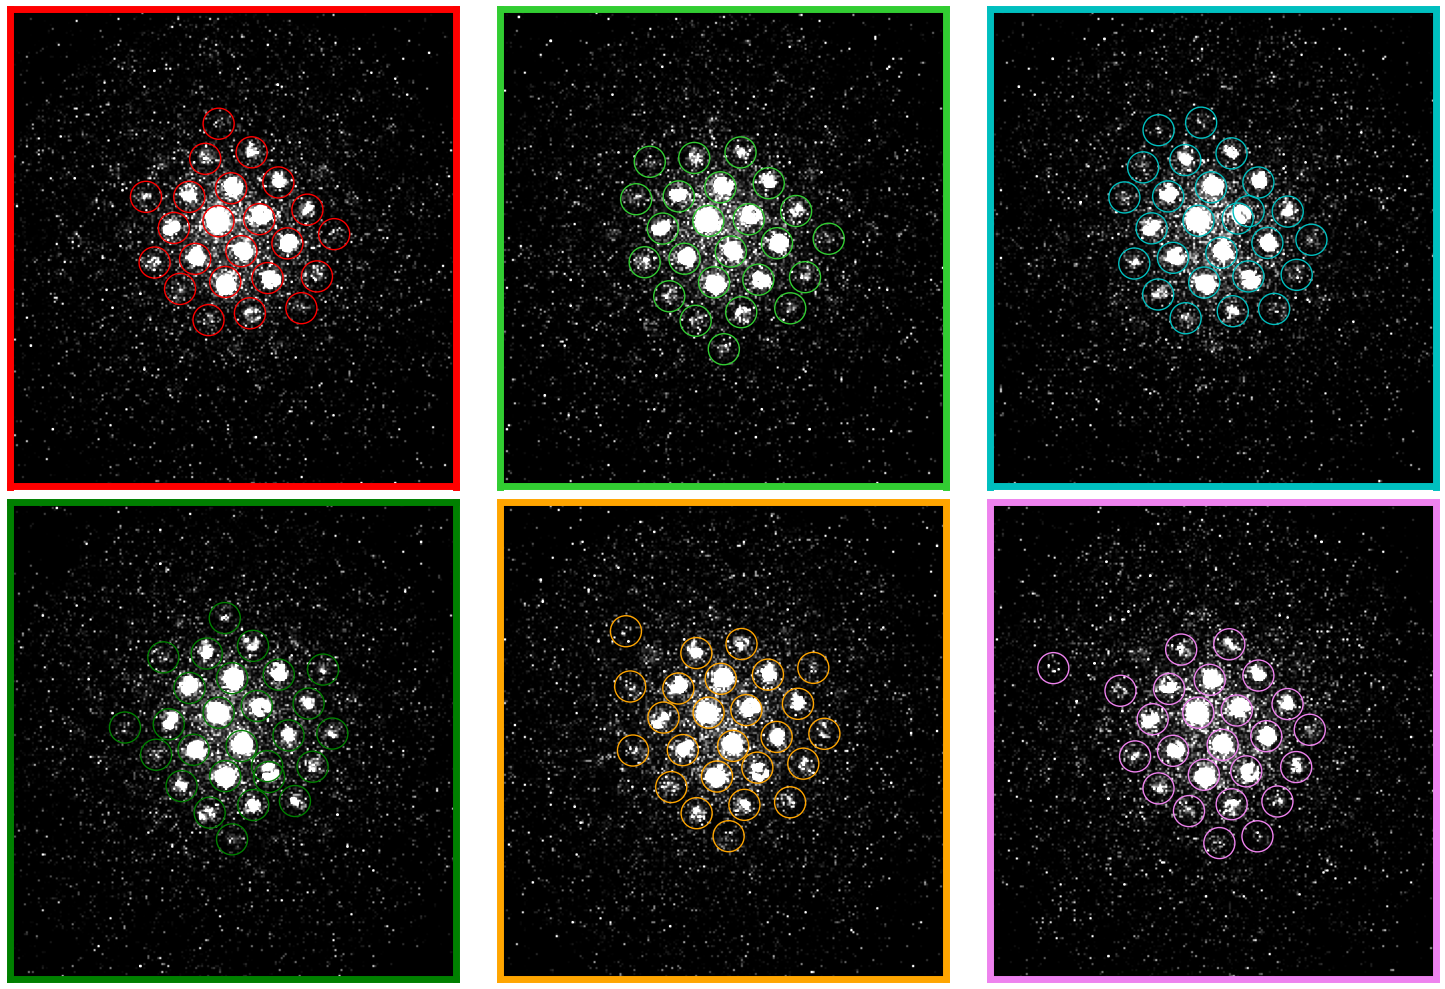

In [12]:
# perform dist detection, tune hyper-parameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 2,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 35,
    'minPeakSpacing': probe_semiangle * 2,
    'subpixel' : 'poly',
#     'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

disks_selected = dc0.find_Bragg_disks(
    data = (rxs, rys),
    template = probe.kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dc0.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 500,
)


In [13]:
bragg_peaks = dc0.find_Bragg_disks(
    template = probe.kernel,
    **detect_params,
)
     

Finding Bragg Disks: 100%|████████████████| 12.0k/12.0k [00:21<00:00, 559DP/s]


In [14]:
bvm_raw = bragg_peaks.histogram(mode = 'raw')


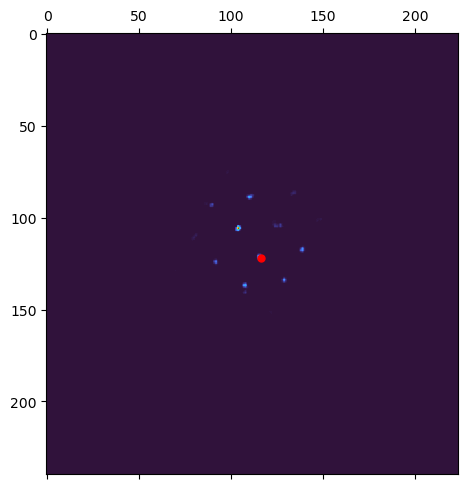

In [15]:
py4DSTEM.show(
    bvm_raw,
    points = {'x':center_guess[0],'y':center_guess[1]},
    # power = 0.5,
    cmap = "turbo",
    vmax = 1
)


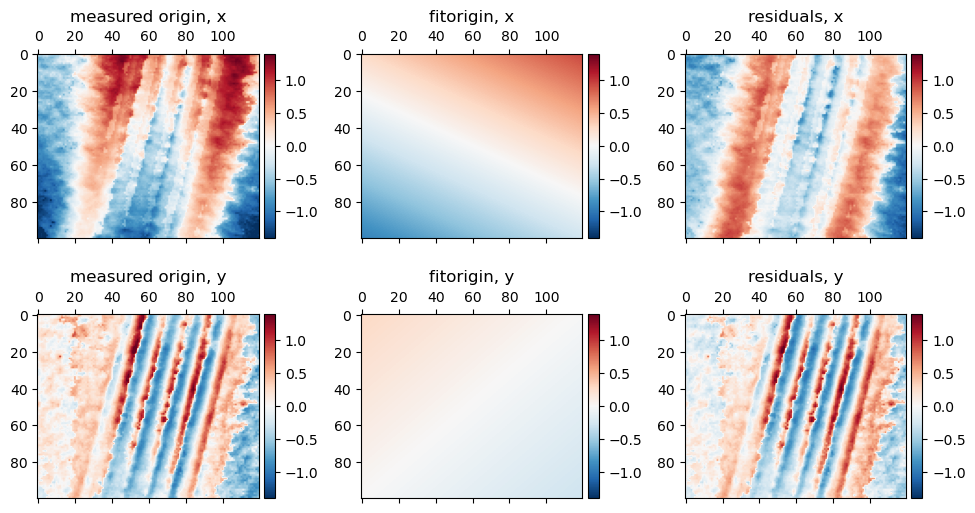

In [16]:
origin_meas = bragg_peaks.measure_origin( center_guess=center_guess )
# fit a 2D plane
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin()



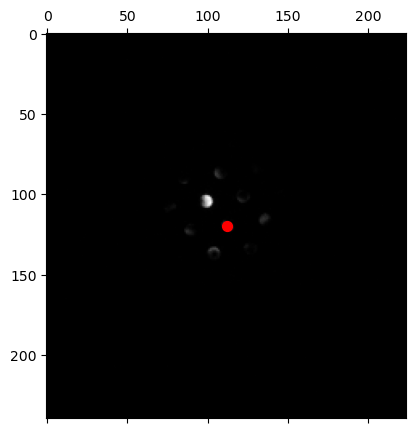

In [17]:
#check center finding
py4DSTEM.visualize.show_points(
    py4DSTEM.process.utils.get_shifted_ar(
        dc0[0,0],
        xshift=(dc0.Qshape[0]/2 - qx0_fit[0,0]),
        yshift=(dc0.Qshape[1]/2 - qy0_fit[0,0]),
        bilinear=True
    ),
    vmax =1,
    x = dc0.Qshape[0]/2,
    y = dc0.Qshape[1]/2
    
)

In [18]:
dc0.data = np.asarray(dc0.data, dtype = "float")

In [19]:
#align data
for a0 in range(dc0.Rshape[0]):
    for a1 in range(dc0.Rshape[1]): 
        dc0.data[a0,a1] = py4DSTEM.process.utils.get_shifted_ar(
            dc0.data[a0,a1],
            xshift=(dc0.Qshape[0]/2 - qx0_fit[a0,a1]),
            yshift=(dc0.Qshape[1]/2 - qy0_fit[a0,a1]),
            bilinear=True
        )

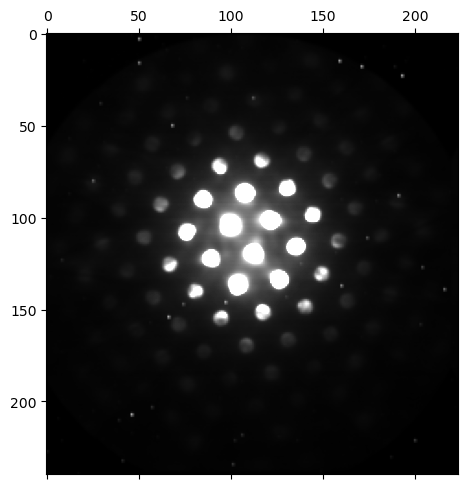

In [20]:
py4DSTEM.show(
    dc0.data.mean((0,1))
    
)

### load other datasets

In [21]:
def load_and_center_datacube(
    dc,
    center_guess,
    pad  = False
):
    probe = py4DSTEM.Probe.generate_synthetic_probe(
        radius = probe_semiangle,
        width = 0.7,
        Qshape = dc.Qshape
    )
    
    probe.get_kernel(
        mode = 'sigmoid',
        origin = (dc.Qshape[0]/2,dc.Qshape[1]/2),
        radii = (probe_semiangle * 1.2,
                 probe_semiangle * 4
        )
    )
    bragg_peaks = dc.find_Bragg_disks(
        probe.kernel,
        **detect_params,
    )
    origin_meas = bragg_peaks.measure_origin( center_guess=center_guess , score_method = "distance")
    qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin()

    if pad == True: 
        shifts_x = dc.Qshape[0]/2 - qx0_fit
        shifts_y = dc.Qshape[1]/2 - qy0_fit
        pad_width = int(np.max((np.abs(shifts_x), np.abs(shifts_y))))
        dc1.data = np.pad(dc1.data, ((0,0), (0,0), (pad_width, pad_width), (pad_width, pad_width)))

    else: 
        pad_width = 0
    
    
    dc.data = np.asarray(dc.data, dtype = "float")
    for a0, a1 in tqdmnd(
        dc.Rshape[0],
        dc.Rshape[1],
        desc="aligning",
        unit="DP",
        unit_scale=True,
    ):
        dc.data[a0,a1] = py4DSTEM.process.utils.get_shifted_ar(
            dc.data[a0,a1],
            xshift=(dc.Qshape[0]/2 - qx0_fit[a0,a1]-pad_width),
            yshift=(dc.Qshape[1]/2 - qy0_fit[a0,a1]-pad_width),
            bilinear=True
        )
    return dc

         

In [22]:
dc1 = py4DSTEM.import_file(file_path_1).bin_Q(2)
dc2 = py4DSTEM.import_file(file_path_2).bin_Q(2)
dc3 = py4DSTEM.import_file(file_path_3).bin_Q(2)
dc4 = py4DSTEM.import_file(file_path_4).bin_Q(2)

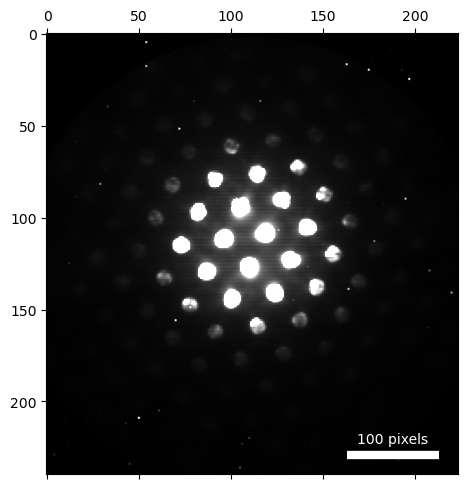

In [23]:
dc1.get_dp_mean()
py4DSTEM.show(
    dc1.tree('dp_mean'),
    # vmax = 1
    
)

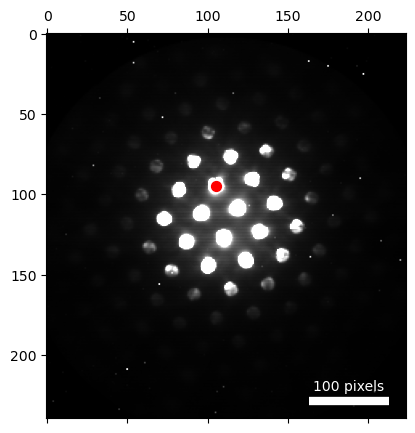

In [24]:
# center_guess = (109, 120)
center_guess = (95, 105)

py4DSTEM.visualize.show_points(
    dc1.tree('dp_mean'),
    x = center_guess[0], 
    y = center_guess[1],
    # vmax = 1
)

Finding Bragg Disks: 100%|████████████████| 12.0k/12.0k [00:21<00:00, 564DP/s]
aligning: 100%|█████████████████████████| 12.0k/12.0k [00:01<00:00, 6.35kDP/s]


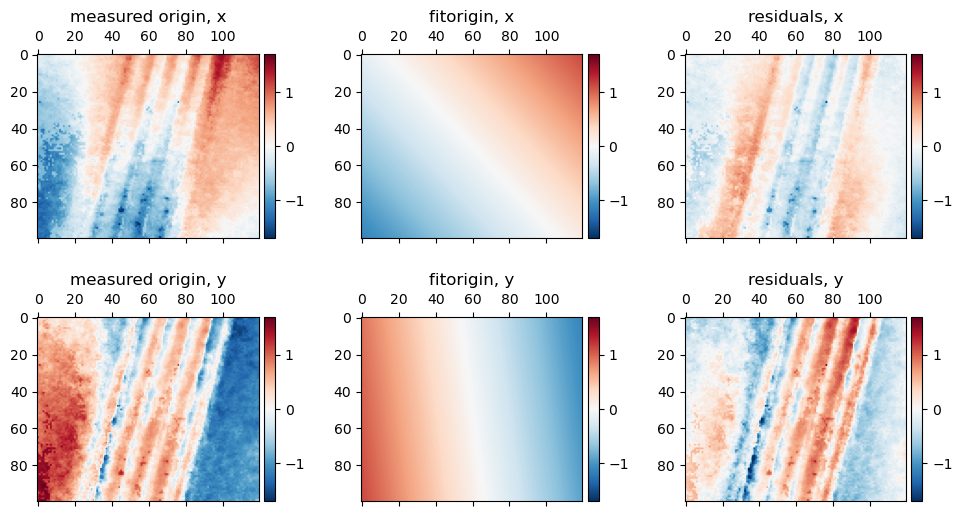

In [25]:
dc1 = load_and_center_datacube(dc1, center_guess = center_guess)

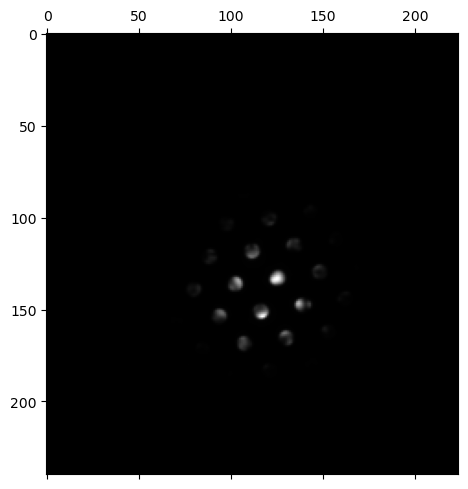

In [26]:
py4DSTEM.show(
    dc1.data.mean((0,1)) ,
    vmax = 1
)

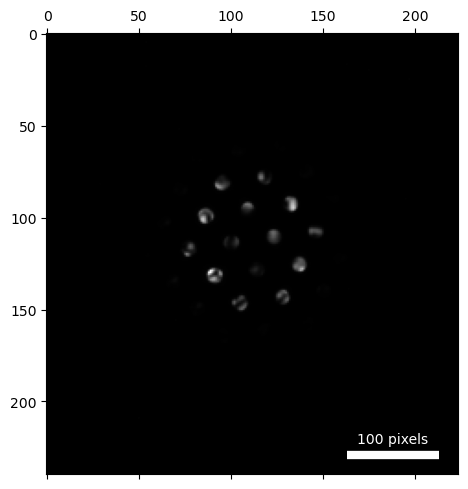

In [27]:
dc2.get_dp_mean()
py4DSTEM.show(
    dc2.tree('dp_mean'),
    vmax = 1
    
)

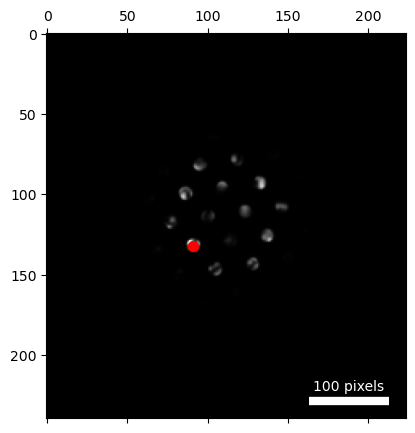

In [28]:
center_guess = (132, 91)

py4DSTEM.visualize.show_points(
    dc2.tree('dp_mean'),
    x = center_guess[0], 
    y = center_guess[1],
    vmax = 1
)

Finding Bragg Disks: 100%|████████████████| 12.0k/12.0k [00:21<00:00, 554DP/s]
aligning: 100%|█████████████████████████| 12.0k/12.0k [00:02<00:00, 5.85kDP/s]


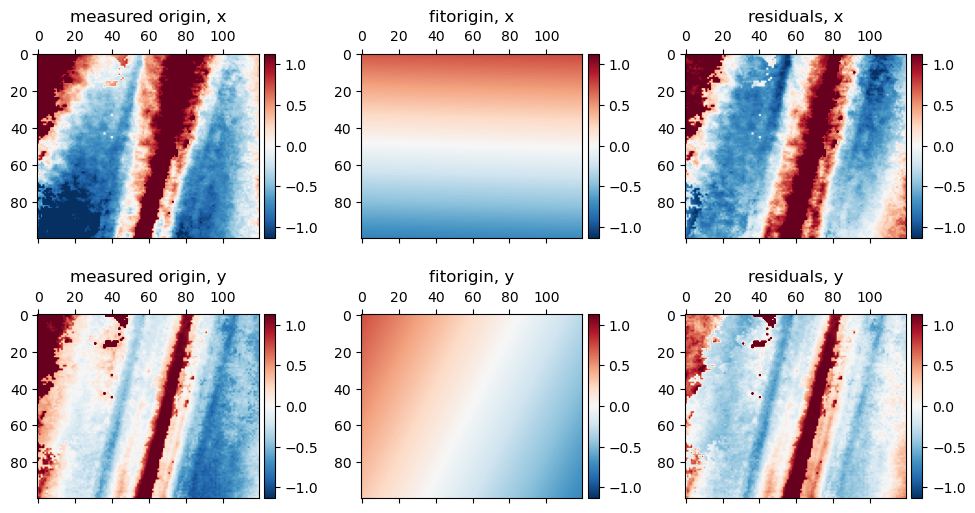

In [29]:
dc2 = load_and_center_datacube(dc2, center_guess = center_guess)

In [30]:
dc3.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (240, 224) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

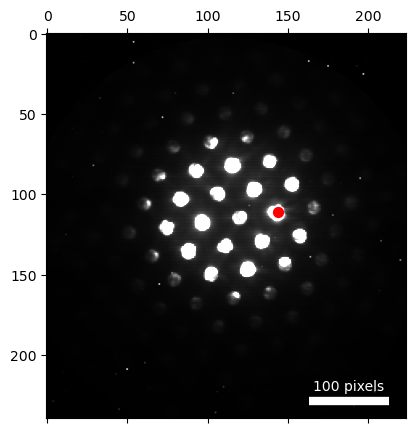

In [31]:
# center_guess = (98, 128)
center_guess = (111, 144)
py4DSTEM.visualize.show_points(
    dc3.tree('dp_mean'),
    x = center_guess[0], 
    y = center_guess[1],
    # vmax = 1
)

Finding Bragg Disks: 100%|████████████████| 12.0k/12.0k [00:21<00:00, 562DP/s]
aligning: 100%|█████████████████████████| 12.0k/12.0k [00:02<00:00, 5.72kDP/s]


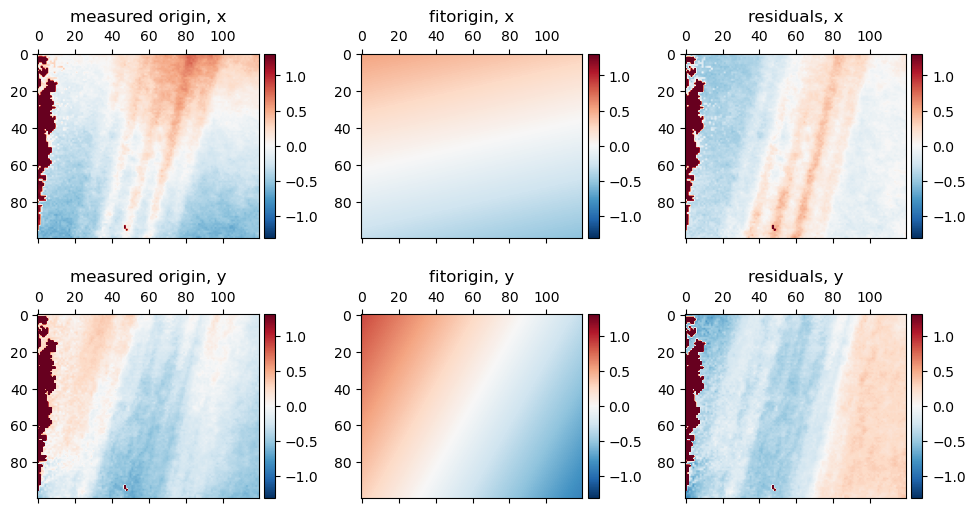

In [32]:
dc3 = load_and_center_datacube(dc3, center_guess = center_guess)

In [33]:
dc4.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (240, 224) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

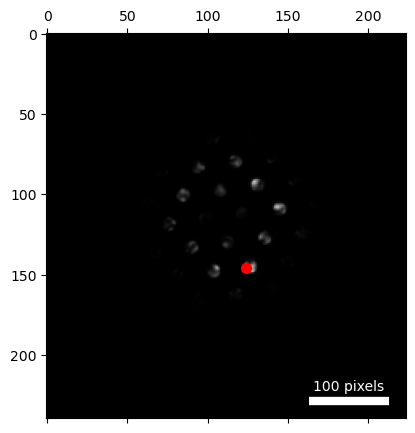

In [34]:
center_guess = (146, 124)

py4DSTEM.visualize.show_points(
    dc4.tree('dp_mean'),
    x = center_guess[0], 
    y = center_guess[1],
    vmax = 1
)

Finding Bragg Disks: 100%|████████████████| 12.0k/12.0k [00:21<00:00, 548DP/s]
aligning: 100%|█████████████████████████| 12.0k/12.0k [00:02<00:00, 5.79kDP/s]


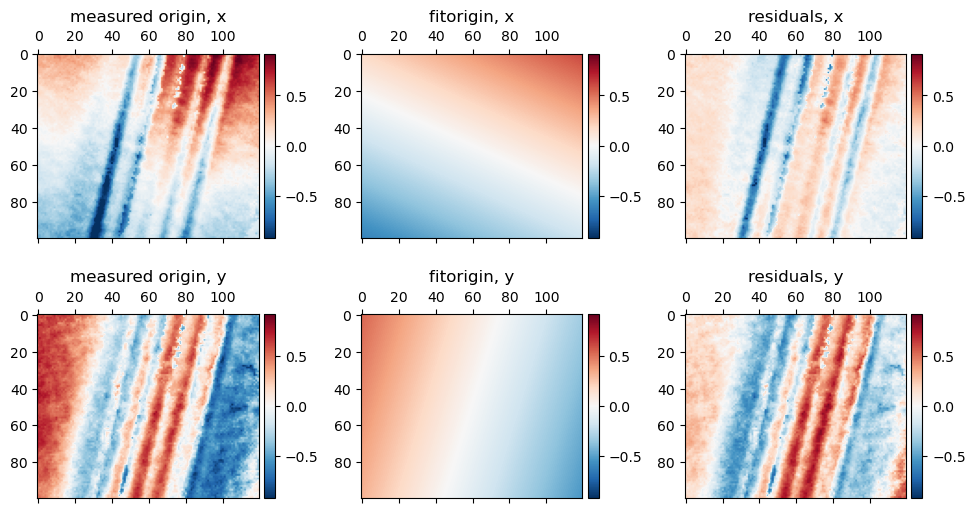

In [35]:
dc4 = load_and_center_datacube(dc4, center_guess = center_guess)

### make virtual images and mean diffraction patterns

100%|████████████████████████████████| 12000/12000 [00:00<00:00, 25845.08it/s]


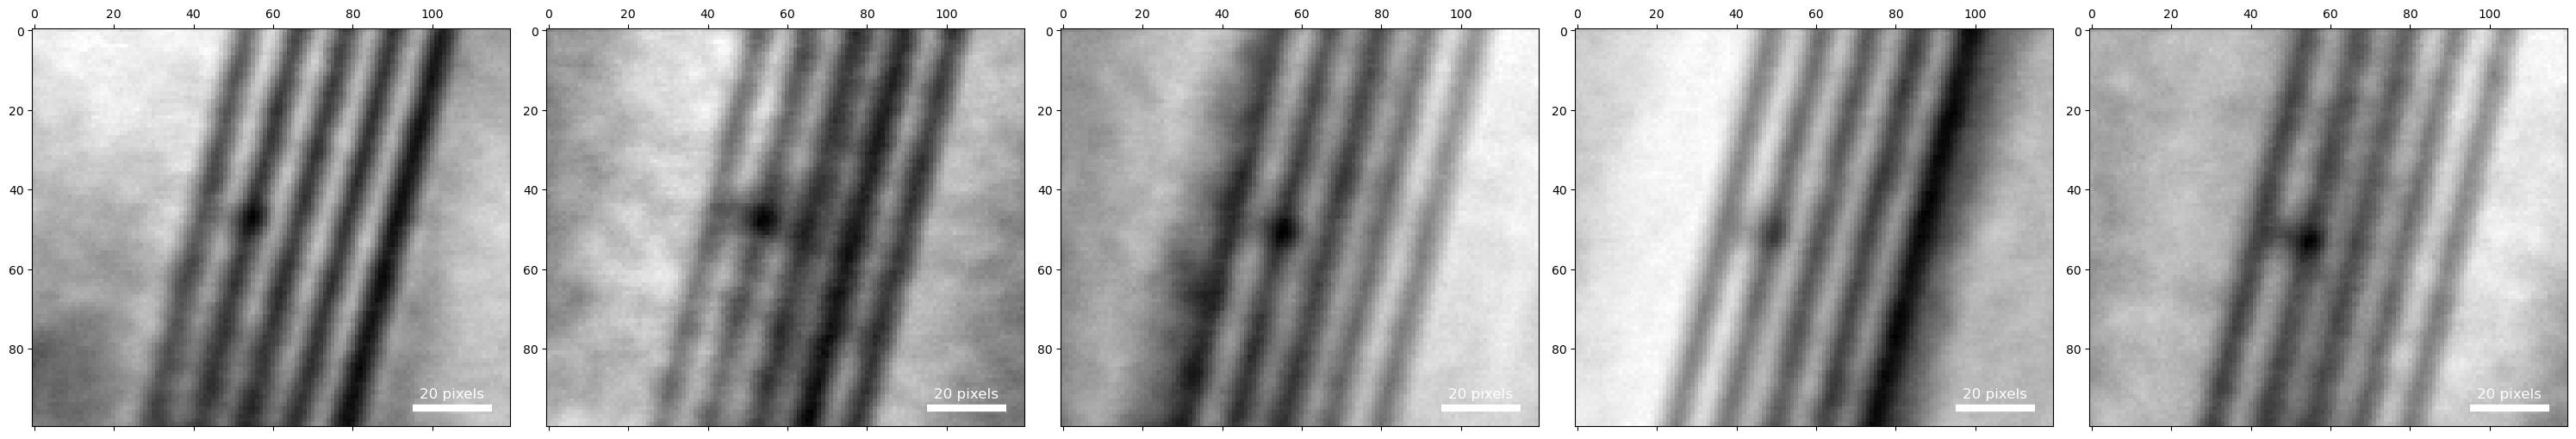

In [36]:

# geometry = ((dc0.Qshape[0]/2,dc0.Qshape[1]/2), probe_semiangle+5)
# mode = "circular"
name = "DF"


geometry = ((dc0.Qshape[0]/2,dc0.Qshape[1]/2), (probe_semiangle + 12, (probe_semiangle + 5) * 10))
mode = "annular"


dc0.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
)

dc1.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)
dc2.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)
dc3.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)
dc4.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)

py4DSTEM.show(
    [
        dc0.tree('DF'),
        dc1.tree('DF'),
        dc2.tree('DF'),
        dc3.tree('DF'),
        dc4.tree('DF'),
        
    ],
    vmax =1,
    vmin = 0
    
)

In [37]:
dc0.get_dp_mean()
dc1.get_dp_mean()
dc2.get_dp_mean()
dc3.get_dp_mean()
dc4.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (240, 224) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

In [38]:
dc0.data.shape

(100, 120, 240, 224)

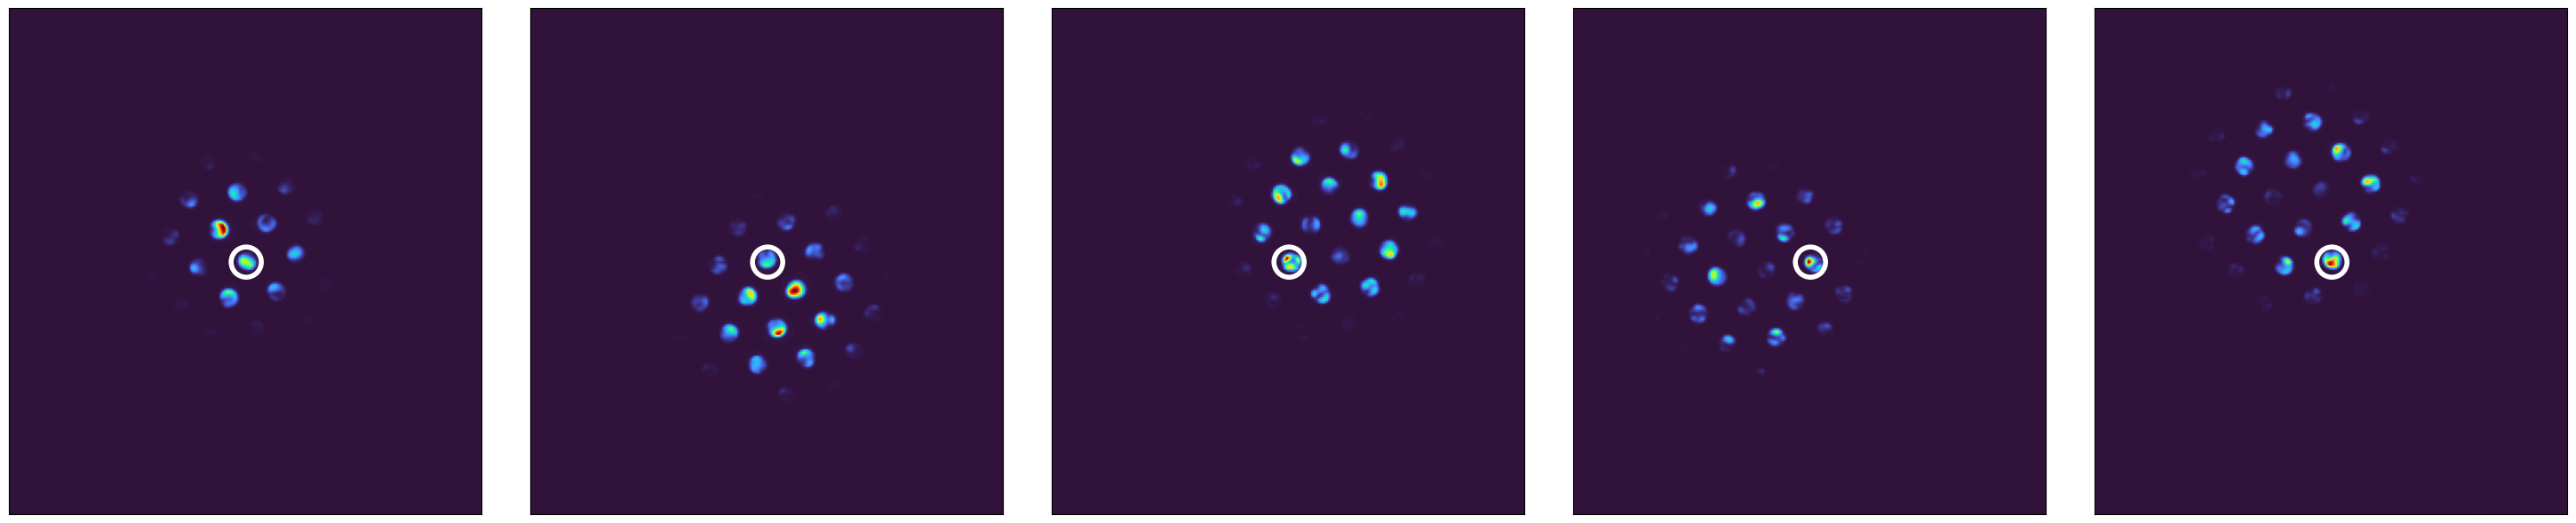

In [39]:
fig, ax = py4DSTEM.show(
    [
        dc0.tree('dp_mean'),
        dc1.tree('dp_mean'),
        dc2.tree('dp_mean'),
        dc3.tree('dp_mean'),
        dc4.tree('dp_mean')
        
    ],
    ticks = False,
    scalebar = False,
    returnfig=True,
    vmax = 1,
    cmap = "turbo"
)


ax[0][0].scatter(dc0.Qshape[1]/2, dc0.Qshape[0]/2, s = 600, facecolors='none', edgecolors='white', alpha = 1, lw = 4)
ax[0][1].scatter(dc1.Qshape[1]/2, dc1.Qshape[0]/2, s = 600, facecolors='none', edgecolors='white', alpha = 1, lw = 4)
ax[0][2].scatter(dc2.Qshape[1]/2, dc2.Qshape[0]/2, s = 600, facecolors='none', edgecolors='white', alpha = 1, lw = 4)
ax[0][3].scatter(dc3.Qshape[1]/2, dc3.Qshape[0]/2, s = 600, facecolors='none', edgecolors='white', alpha = 1, lw = 4)
ax[0][4].scatter(dc2.Qshape[1]/2, dc4.Qshape[0]/2, s = 600, facecolors='none', edgecolors='white', alpha = 1, lw = 4)


plt.tight_layout()
plt.savefig('DPs_K2.pdf', bbox_inches = "tight")


### combine datasets



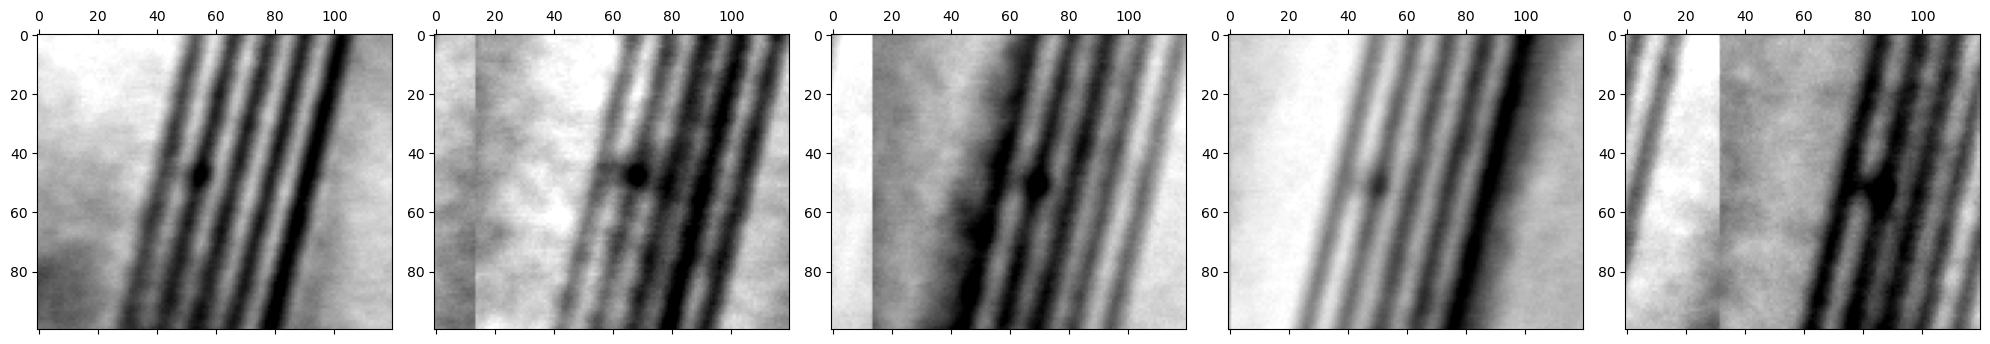

In [43]:
shifts = np.zeros((5,2))

mask = np.zeros(dc0.Rshape)
mask[20:80,:] = 1


# py4DSTEM.show(mask)
shifts[1]= phase_cross_correlation(
    dc0.tree('DF').data,
    dc1.tree('DF').data,
    # reference_mask = mask
)[0]

shifts[2]=  phase_cross_correlation(
    dc1.tree('DF').data,
    dc2.tree('DF').data,
    # reference_mask = mask
)[0]


shifts[3]=  phase_cross_correlation(
    dc1.tree('DF').data,
    dc3.tree('DF').data,
    # reference_mask = mask
)[0]

shifts[4]=  phase_cross_correlation(
    dc3.tree('DF').data,
    dc4.tree('DF').data,
    # reference_mask = mask
)[0]

#becuase cross-correlation is based on first dataset

shifts[2] = shifts[2] + shifts[1]
shifts[3] = shifts[3] + shifts[1]
shifts[4] = shifts[4] + shifts[3]

shifts = np.asarray(shifts, dtype = "int")

# plotting to verify 

fig, ax= py4DSTEM.show(
    [
        dc0.tree('DF').data,
        np.roll(dc1.tree('DF').data,shift=shifts[1], axis=(0,1)),
        np.roll(dc2.tree('DF').data,shift=shifts[2], axis=(0,1)),
        np.roll(dc3.tree('DF').data,shift=shifts[3], axis=(0,1)),
        np.roll(dc4.tree('DF').data,shift=shifts[4], axis=(0,1)),
        # np.roll(dc2.tree('DF').data,shift=shifts_manual[1], axis=(1,0)),
    ],
    returnfig=True,
    axsize = (4,4),
    
)

# for axs in ax.flatten(): 
#     axs.axhline(50, 0,100,)
#     axs.axhline(100, 0,100,)
#     axs.axhline(150, 0,100,)
#     axs.axhline(200, 0,100,)

#     axs.axvline(50, 0,100,)
#     axs.axvline(100, 0,100,)
#     axs.axvline(150, 0,100,)
#     axs.axvline(200, 0,100,)

In [44]:
## automated cross correlation prooved challenging, so I did it manually below

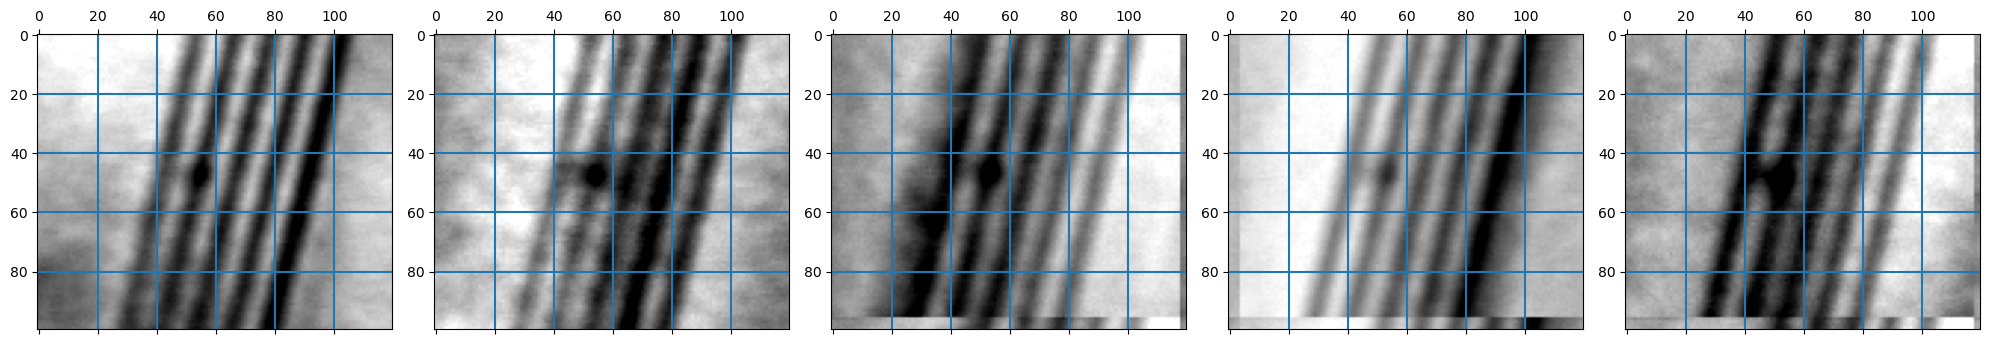

In [45]:
shifts = np.zeros((5,2))
shifts[2] = np.array([-4,-2])
shifts[3] = np.array([-4,4])
shifts[4] = np.array([-4,-2])
shifts = np.array(shifts, dtype = "int")
fig, ax= py4DSTEM.show(
    [
        dc0.tree('DF').data,
        np.roll(dc1.tree('DF').data,shift=shifts[1], axis=(0,1)),
        np.roll(dc2.tree('DF').data,shift=shifts[2], axis=(0,1)),
        np.roll(dc3.tree('DF').data,shift=shifts[3], axis=(0,1)),
        np.roll(dc4.tree('DF').data,shift=shifts[4], axis=(0,1)),
        # np.roll(dc2.tree('DF').data,shift=shifts_manual[1], axis=(1,0)),
    ],
    returnfig=True,
    axsize = (4,4),
    
)



for axs in ax.flatten(): 
    axs.axhline(20, 0,100,)
    axs.axhline(40, 0,100,)
    axs.axhline(60, 0,100,)
    axs.axhline(80, 0,100,)

    axs.axvline(20, 0,100,)
    axs.axvline(40, 0,100,)
    axs.axvline(60, 0,100,)
    axs.axvline(80, 0,100,)
    axs.axvline(100, 0,100,)



In [46]:
crop_x_min = np.min(shifts[:,0])
crop_x_max = np.max(shifts[:,0])
crop_x_range = crop_x_max -crop_x_min

crop_y_min = np.min(shifts[:,1])
crop_y_max = np.max(shifts[:,1])
crop_y_range = crop_y_max -crop_y_min

In [47]:
print(crop_x_min, crop_x_max, crop_y_min, crop_y_max)

-4 0 -2 4


In [48]:
dc_combined = np.zeros(
    (
        dc0.shape[0],
        dc0.shape[1],
        dc0.shape[2],
        dc0.shape[3],
    )
)

In [49]:
datacubes = [dc0, dc1, dc2, dc3, dc4]
for a0 in range(5): #range(shifts_manual.shape[0]):
    dc_combined = dc_combined + np.roll(
        datacubes[a0].data.copy(),
        shifts[a0], 
        axis = (0,1)
    )

In [50]:
BF = dc_combined.mean((2,3))

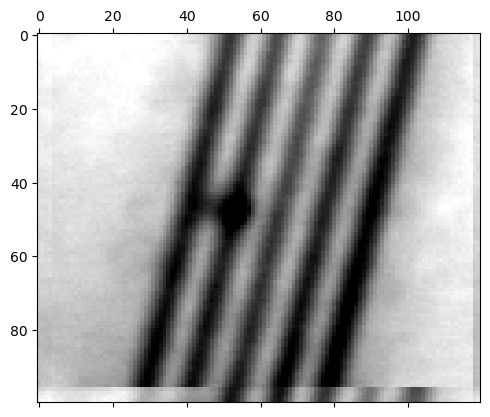

In [51]:
py4DSTEM.show(
    BF,
)

In [52]:
dc_combined_cropped = dc_combined.copy()[
        crop_x_max:crop_x_min,
        crop_y_max:crop_y_min,
    ]

In [53]:
dc_combined_cropped_mean = dc_combined_cropped.mean((0,1))

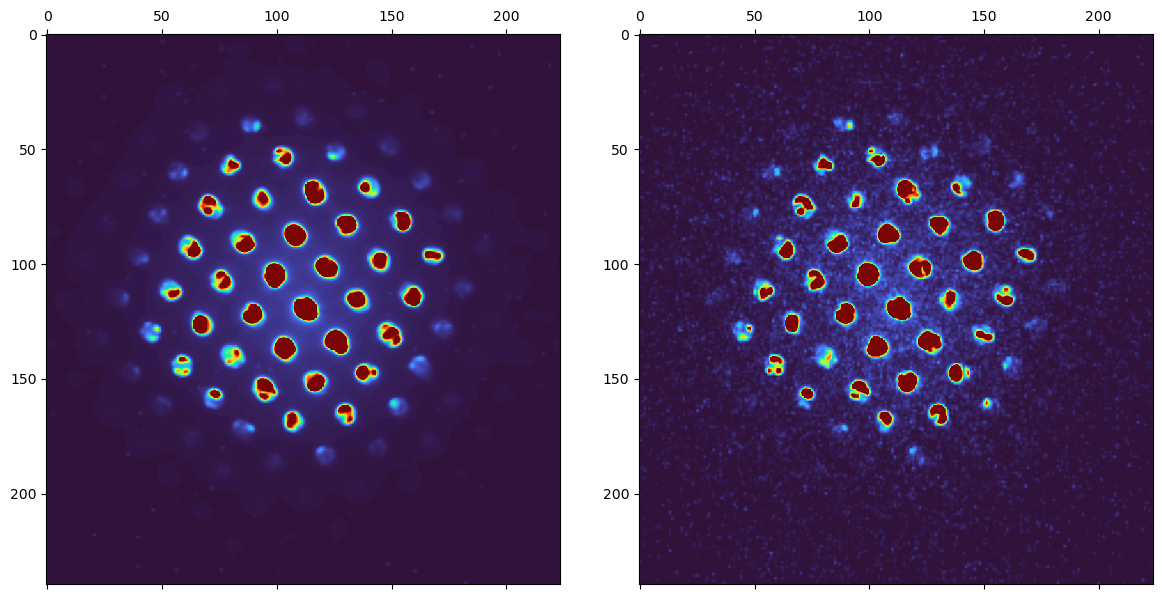

In [54]:
py4DSTEM.show(
    [
        dc_combined_cropped_mean,
        dc_combined_cropped[20,20]
        
    ],
    cmap = "turbo"
    
)

In [55]:
dc_combined_save = py4DSTEM.DataCube(
    data = dc_combined_cropped
    
)

In [56]:
py4DSTEM.save(
    'dc_combined_K2.h5',
    dc_combined_save,
    "o"
    
)